In [2]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage.filters import median_filter, convolve
from scipy.ndimage import generic_filter
from skimage.morphology import opening, closing, erosion, dilation, skeletonize
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, estimate_sigma
from skimage.filters import threshold_local, gaussian
from skimage import measure 
from skimage.draw import circle_perimeter
import cv2

## Leitura da imagem
Utilizamos a biblioteca imageio para realizar a leitura da imagem.

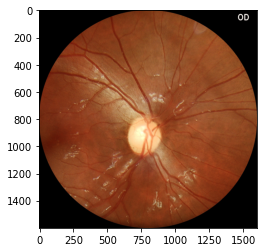

In [3]:
img = imageio.imread('images/4.jpg')
plt.imshow(img)

## Pré-Processamento
Nessa etapa do projeto são realizados diversos processamento na imagem visando obter uma melhor representação dos vasos sanguíneos presentes no exame de retina. 

### Canal Verde
Inicialmente, selecionamos apenas o canal verde de uma imagem, que nos traz uma boa representação dos vasos e diminui a quantidade de dados a serem processados (de 3 para 1 canal de cor apenas).

(1600, 1600)


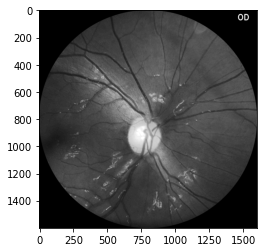

In [4]:
img_g = img[:,:,1]
print(img_g.shape)
plt.imshow(img_g,cmap='gray')

### Abertura (Opening)
Realizamos então a abertura da imagem para remover parte das sombras e das reflexões (manchas brancas) presentes na imagem, visando obter uma imagem mais próxima da real, sem influência da câmera utilizada.

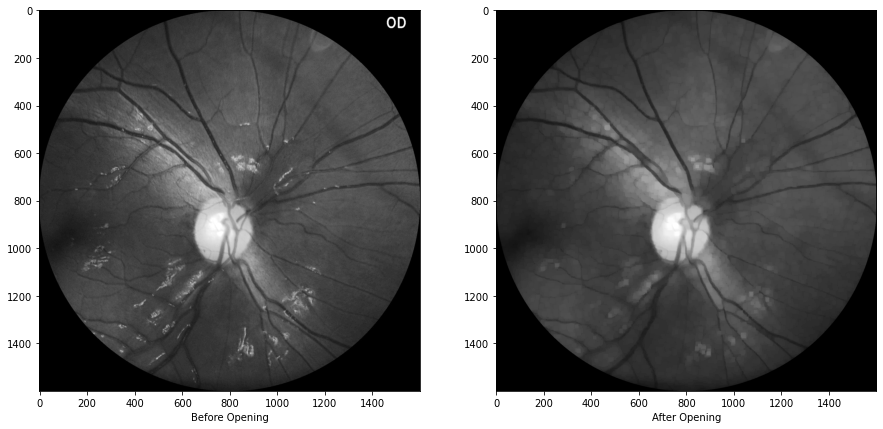

In [5]:
ker = np.ones((13, 13))
img_opening = opening(img_g, ker)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.xlabel('Before Opening')
plt.imshow(img_g, cmap="gray")
plt.subplot(122)
plt.xlabel('After Opening')
plt.imshow(img_opening, cmap="gray")


A função abaixo foi criada para facilitar o processamento dos próximos passos. Essa função recebe uma imagem e a processa, seguindo o tamanho de núcleo e o tipo de filtro indicados. Realiza processamentos com filtros de média, mediana e gaussianos.

In [6]:
def filter_img(img, kernel_size=3, filter_type="mean"):
    if filter_type == "mean":
        weights = np.full((kernel_size, kernel_size), 1.0/(kernel_size**2))
        return convolve(img, weights=weights, mode="constant", cval=0)
    elif filter_type == "median":
        return median_filter(img, size=kernel_size)
    elif filter_type == "gaussian":
        kernel = np.zeros((kernel_size, kernel_size))
        kernel[kernel_size//2, kernel_size//2] = 1
        kernel = gaussian(kernel, sigma=1, mode='reflect')
        return convolve(img, weights=kernel, mode="constant", cval=0)
    else:
        print('Error! Filter should be either mean, median or gaussian!')
        return None

### Cálculo do Background (Plano de Fundo)
Então, com o objetivo final de isolar os vasos sangúineos foram utilizados diversos filtros na imagem buscando retirar dela o plano de fundo. A ideia é de, obtendo o fundo da imagem, removê-lo dela, ficando assim com apenas as partes mais relevantes, que no caso são os vasos sanguíneos.   
Para obter o background da imagem os filtros utilizados foram:
* filtro média com tamanho 13, seguido de;
* filtro gaussiano de tamanho 15;
* filtro mediana de tamanho 60;

A ideia com essa sequência de filtros era de borrar a imagem original, fazendo com que perdesse todos os detalhes mais finos (que no caso seriam os vasos sanguíneos), gerando uma imagem de como seria o exame sem os vasos sangúineos.

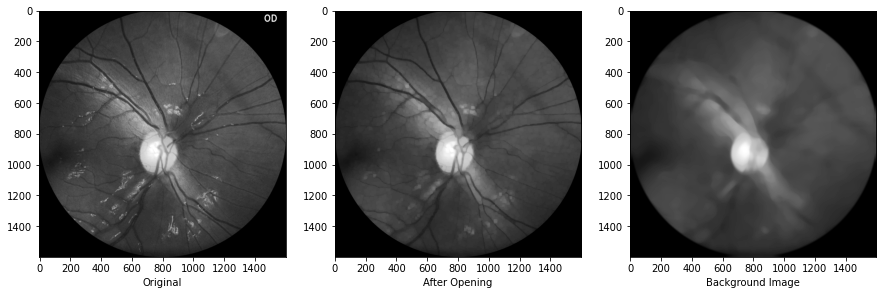

In [7]:
background = filter_img(img_opening, kernel_size=13, filter_type="mean")
background = filter_img(background, kernel_size=15, filter_type="gaussian")
background = filter_img(background, kernel_size=60, filter_type="median")

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.xlabel("Original")
plt.imshow(img_g, cmap="gray")
plt.subplot(132)
plt.xlabel("After Opening")
plt.imshow(img_opening, cmap="gray")
plt.subplot(133)
plt.xlabel("Background Image")
plt.imshow(background, cmap="gray")

As funções abaixo foram retiradas dos códigos fornecidos pelo professor da disciplina. A ideia que tivemos ao usá-las era de melhorar a diferenciação nos níveis de cor da imagem. Isso trouxe uma melhora significativa na visualização dos vasos (por olhos humanos), mas não impactou de maneira tão positiva o processamento realizado sobre a imagem.

De qualquer maneira, deixamos a representação da imagem, pois foi um dos caminhos que seguimos, antes de mudarmos de direção.

In [8]:
def histogram(A, no_levels):
    # gets the size of the input matrix
    N, M = A.shape
    # creates an empty histogram with size proportional to the number of graylevels 
    hist = np.zeros(no_levels).astype(int)

    # computes for all levels in the range
    for i in range(no_levels):
        # sum all positions in which A == i is true
        pixels_value_i = np.sum(A == i)
        # store it in the histogram array
        hist[i] = pixels_value_i
            
    return(hist)

def histogram_equalization(A, no_levels):
    # computes the image histogram
    hist = histogram(A,  no_levels)
    
    # creates an empty cumulative histogram
    histC = np.zeros(no_levels).astype(int)

    # computes the cumulative histogram
    histC[0] = hist[0] # first value (intensity 0)
    # from intensity 1 to no_levels-1
    for i in range(1,  no_levels):
        histC[i] = hist[i] + histC[i-1]

    # the vector below is used to store the actual transformation function
    # it allows us to later visualize what was the function that computed
    # the equalisation
    hist_transform = np.zeros(no_levels).astype(np.uint8)
    
    # gets the size of the input image
    N, M = A.shape
    
    # create the image to store the equalised version
    A_eq = np.zeros([N,M]).astype(np.uint8)
    
    # for each intensity value, transforms it into a new intensity
    # using the np.where() function 
    for z in range(no_levels):
        # computes what would be the output level 's' for an input value 'z'
        s = ((no_levels-1)/float(M*N))*histC[z]
        
        # for every coordinate in which matrix A has the value 'z'
        # assigns the transformed/equalised value 's'
        A_eq[ np.where(A == z) ] = s
        
        # store the tranformation function
        hist_transform[z] = s
    
    return (A_eq, hist_transform)

### Remoção do Background

Então calculamos a diferença (uma subtração simples) da imagem com o background calculado. Isso visa obter uma imagem apenas com as partes de nosso interesse: os vasos sanguíneos. 

Porém como parecia ser difícil a visualização dos vasos, realizamos o cálculo de equalização por meio de histograma e mostramos a imagem de resultado. Em termos humanamente visuais, é mais fácil distinguir os vasos na imagem equalizada, mas muito barulho é inserido, o que acaba atrapalhando o resto dos processos (tentamos seguir esse caminho e não obtivemos bons resultados). Por esse motivo, acabamos deixando esse processamento de lado.

Text(0.5, 0, 'Equalized histogram')

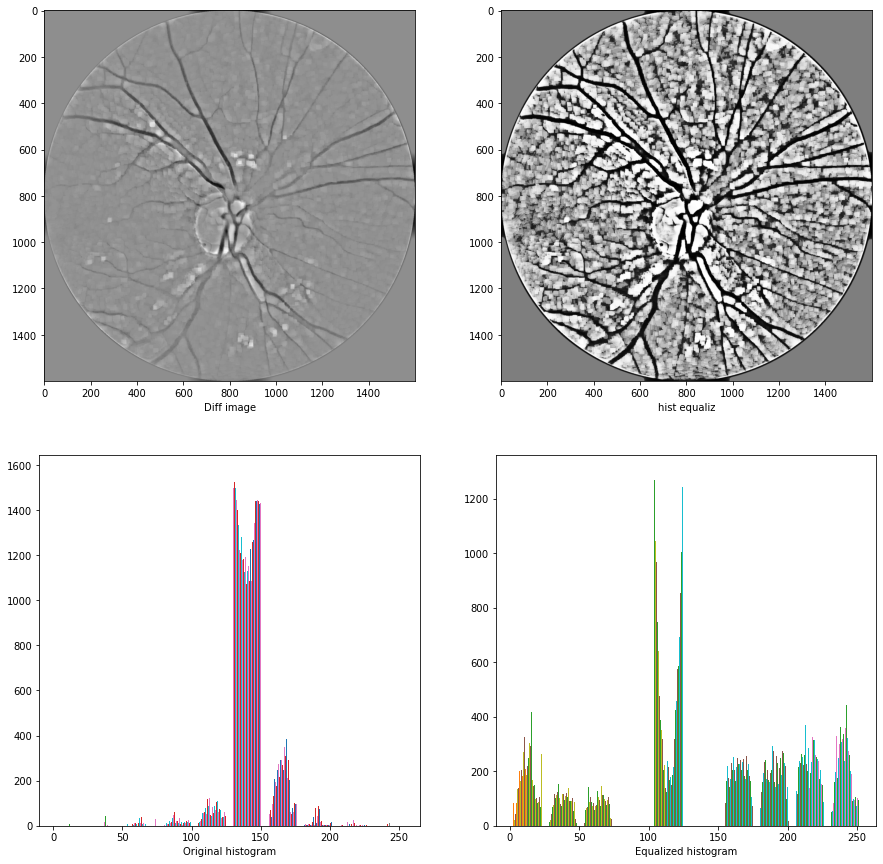

In [9]:
diff_img = img_opening.astype(np.int64) - background.astype(np.int64)
diff_img = ((diff_img - np.min(diff_img)) / (np.max(diff_img) - np.min(diff_img))*255).astype(np.uint8)
diff_img_eq, _ = histogram_equalization(diff_img, 256)

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.xlabel("Diff image")
plt.imshow(diff_img, cmap="gray")

plt.subplot(222)
plt.xlabel("hist equaliz")
plt.imshow(diff_img_eq, cmap="gray")

plt.subplot(223)
plt.xlabel('Original histogram')
plt.hist(diff_img)

plt.subplot(224)
plt.hist(diff_img_eq)
plt.xlabel('Equalized histogram')

## Thresholding
Então, passamos a parte principal do trabalho: a segmentação. Nessa etapa utilizamos a imagem obtida anteriormente (sem a realização da equalização por histograma) para o cálculo de uma nova imagem utilizando a técnica de segmentação conhecida como thresholding.

A ideia por trás da aplicação desse método era de obter uma imagem que dividisse as regiões mais escuras das mais claras na imagem (no caso os vasos sanguíneos eram as partes mais escuras). Então foram aplicados dois métodos de thresholding: um global e um adaptativo (ou local). O global define um valor global e separa valores maiores e menores que ele em duas classes. O local se adapta às várias regiões da imagem, tentando trazer um resultado mais fiel do que o global (caso haja diferença em iluminação no decorrer da imagem, por exemplo). 

Inicialmente os resultados do threshold global pareceram ser bem melhores do que o adaptativo, mas no decorrer do processo (na realidade no próximo passo realizado) o threshold adaptativo trouxe melhor resultado.

Text(0.5, 0, 'Adaptive threshold')

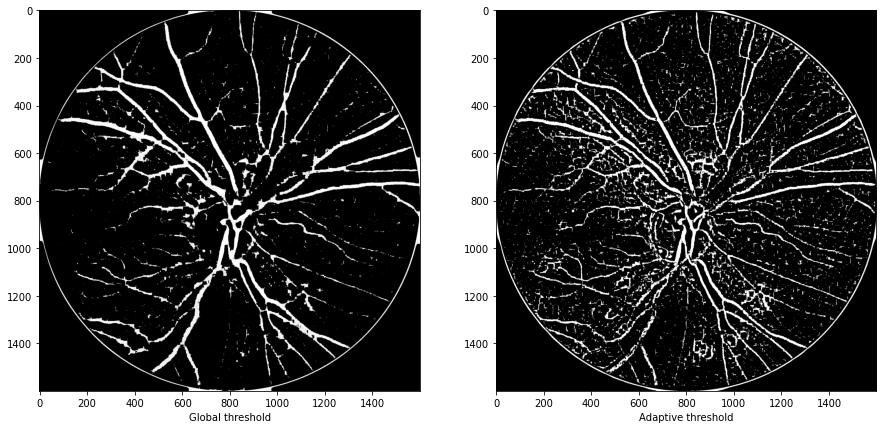

In [10]:
_, global_thresh = cv2.threshold(np.bitwise_not(diff_img_eq), 230, 255, cv2.THRESH_TOZERO)
adaptive_thresh = cv2.adaptiveThreshold(diff_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 41, 5)
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(global_thresh, cmap="gray")
plt.xlabel('Global threshold')
plt.subplot(122)
plt.imshow(adaptive_thresh, cmap="gray")
plt.xlabel('Adaptive threshold')

## Pós-Processamento
### Operadores morfológicos
Com as imagens devidamente segmentadas, iniciamos o processamento com operadores morfológicos, afim de obter uma melhor definição dos vasos. 

Foram aplicados os operadores de fechamento e abertura em sequência. A ideia com esse operador (de closing) era de expandir a área branca da imagem, buscando unir vasos que tinham sido espaçados. A partir dessa imagem com melhores junções de vasos então buscamos remover o ruído pelo outro operador (que no caso foi opening). 

Um fato estranho que percebemos foi a aparente inversão dos operadores: o esperado é que o opening "aumentasse" a parte branca, preenchendo ligações de vasos e o closing removesse os pequenos pontos. Acreditamos que essa inversão pode acontecer na conversão de tipos de `bool` (resultado do threshold) para `uint8`. Mas o fato mais importante é, apenas estão invertidos, então ao invés de aplicarmos opening e depois closing (que seria o que gostaríamos de aplicar), aplicamos closing e depois opening, obtendo o resultado esperado.

Text(0.5, 0, 'Adaptive threshold after closing and opening')

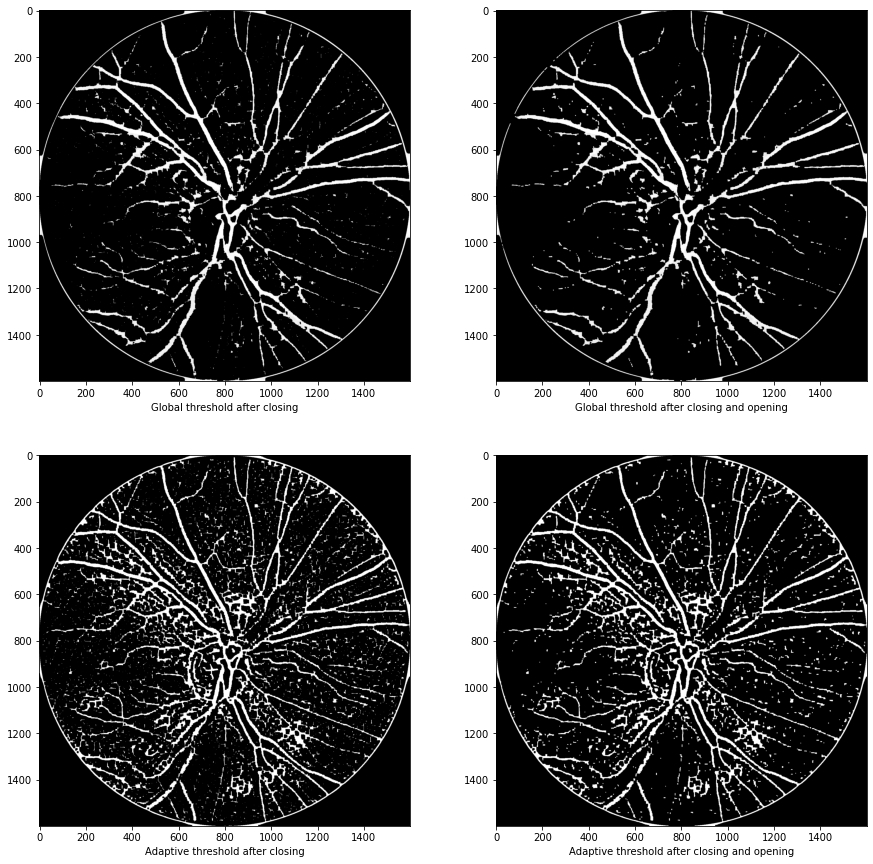

In [11]:
global_thresh_clo = closing(global_thresh.astype(np.uint8), np.ones((3,3)))
global_thresh = opening(global_thresh_clo.astype(np.uint8), np.ones((3,3)))
adaptive_thresh_clo = closing(adaptive_thresh.astype(np.uint8), np.ones((7,7)))
adaptive_thresh = opening(adaptive_thresh_clo.astype(np.uint8), np.ones((3,3)))

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(global_thresh_clo, cmap='gray')
plt.xlabel('Global threshold after closing')
plt.subplot(222)
plt.imshow(global_thresh, cmap='gray')
plt.xlabel('Global threshold after closing and opening')
plt.subplot(223)
plt.imshow(adaptive_thresh_clo, cmap='gray')
plt.xlabel('Adaptive threshold after closing')
plt.subplot(224)
plt.imshow(adaptive_thresh, cmap='gray')
plt.xlabel('Adaptive threshold after closing and opening')

### Remover áreas pequenas
Agora, para obtermos uma imagem que possua apenas os vasos, precisamos remover o barulho gerado junto a imagem nas etapas anteriores. Para fazer isso utilizamos como base um artigo (encotrado [aqui](https://medium.com/swlh/image-processing-with-python-connected-components-and-region-labeling-3eef1864b951)) e ralizamos a divisão da imagem em regiões, fazendo o mapeamento delas de acordo com o tamanho para selecionar apenas as regiões com maior tamanho, ou seja, jogando fora os pontos de barulho que tendem a ser menores.

A função abaixo faz exatamente esse processo: divide a imagem em várias regiões, escolhendo entre elas apenas as que possuem uma determinada área mínima (pelo parâmetro `min_area`). Então é formada uma nova imagem com apenas as regiões que respeitam essa área mínima.

In [26]:
# https://medium.com/swlh/image-processing-with-python-connected-components-and-region-labeling-3eef1864b951
def remove_small_areas(img, min_area):
    label_img = measure.label(img, background=0 ,connectivity=2)
    regions = measure.regionprops(label_img)

    masks = []
    bbox = []
    list_of_index = []
    for num, x in enumerate(regions):
        area = x.area
        if (area>min_area):
            masks.append(regions[num].convex_image)
            bbox.append(regions[num].bbox)   
            list_of_index.append(num)

    for box, mask in zip(bbox, masks):
        reduced_img = img[box[0]:box[2], box[1]:box[3]] * mask

    mask = np.zeros_like(label_img)
    for x in list_of_index:
        mask += (label_img==x+1).astype(int)
    reduced_img  =  img * mask

    return reduced_img


Então, utilizamos a função para tentar remover os pontos (áreas pequenas) da imagem. Os resultados foram bem satisfatórios com a imagem gerada pelo threshold adaptativo, enquanto que a gerada pelo threshold global gerou muitas perdas de informação. A partir desse ponto escolhemos utilizar a imagem gerada pelo processo adaptativo. 

Text(0.5, 0, 'Adaptive threshold after removing small areas')

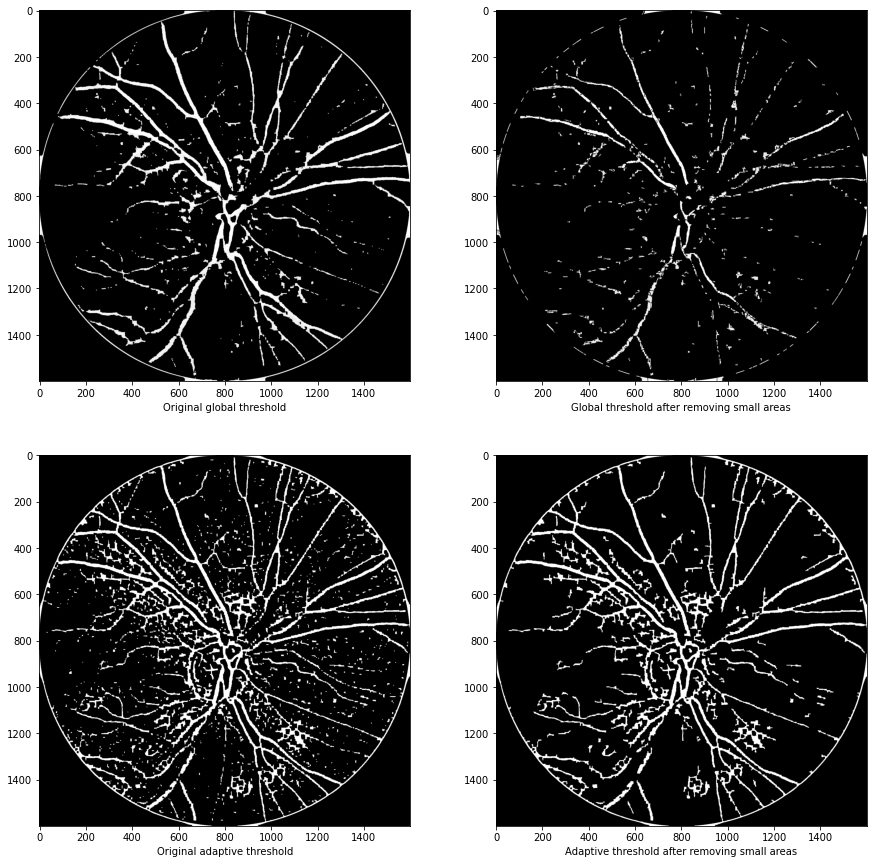

In [27]:
reduced_global = remove_small_areas(global_thresh, 30)
reduced_adaptive = remove_small_areas(adaptive_thresh, 150)
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(global_thresh, cmap="gray")
plt.xlabel('Original global threshold')
plt.subplot(222)
plt.imshow(reduced_global, cmap="gray")
plt.xlabel('Global threshold after removing small areas')

plt.subplot(223)
plt.imshow(adaptive_thresh, cmap="gray")
plt.xlabel('Original adaptive threshold')
plt.subplot(224)
plt.imshow(reduced_adaptive, cmap="gray")
plt.xlabel('Adaptive threshold after removing small areas')

### Esqueletização
Após gerar uma imagem contendo apenas os vasos sanguíneos (ainda existia um pouco de barulho, mas enfim) passamos para o processo de esqueletização. Nessa etapa a ideia é obter uma imagem que descreva por onde vasos sanguíneos passam, sem se importar com sua espessura.   
Essa imagem esqueletizada será usada para a geração de ponto candidatos a serem bifurcações e também para a verificação se de fato dado ponto é uma bifurcação.

Text(0.5, 0, 'Adatptive threshold skeleton')

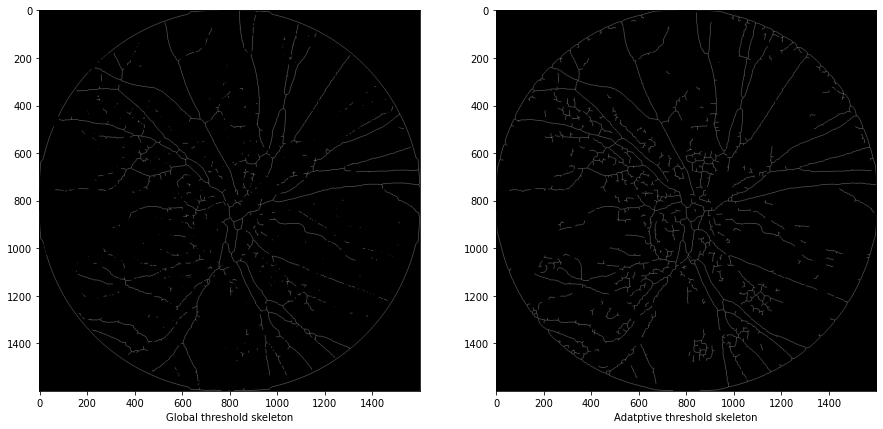

In [28]:
global_skeleton = skeletonize(global_thresh.astype(bool))
adaptive_skeleton = skeletonize(reduced_adaptive.astype(bool))
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(global_skeleton, cmap="gray")
plt.xlabel('Global threshold skeleton')
plt.subplot(122)
plt.imshow(adaptive_skeleton, cmap='gray')
plt.xlabel('Adatptive threshold skeleton')

## Cálculo de bifurcações
Então, com o esqueleto e a imagem dos vasos sanguíneos em mãos, passamos para o processo de calcular onde se encontram as bifurcações da imagem. Para isso seguimos o processo de marcar potenciais bifurcações e depois, com auxílio de funções que medem a largura de um vaso, verificamos a possibilidade do ponto ser de fato uma bifurcação.

### Marcando Referências
HELP BETO

In [29]:
def mark_potential_landmark(img):
    size = 3
    a = size//2
    mask = np.ones((size,size))
    mask[1:-1,1:-1] = 0
    mask = mask.astype(bool)
    N,M = img.shape
    landmarks = []
    coords = np.argwhere(img)
    for (x,y) in coords:
      #inside circle
      if(x-a < 0 or y-a < 0 or x+a+1 > N or y+a+1 > M ):
        continue
      sub_img = img[x-a:x+a+1, y-a:y+a+1]
      img_sum = np.sum(np.bitwise_and(sub_img, mask))
      if(img_sum == 3 or img_sum == 4):
          landmarks.append((x,y))
    return landmarks

Então, para a imagem do esqueleto, chamamos a função e capturamos todas as potenciais referências de bifurcações.

In [30]:
land = mark_potential_landmark(adaptive_skeleton)
len(land)

1835

Para entender melhor se o processo estava funcionando, realizamos um plot dos vários pontos gerados pela função de marcação. Verificamos então que, como o esperado, os pontos marcados estavam sobre linhas, o que nos mostrou que de fato o algoritmo estava funcionando.

Text(0.5, 0, 'Adaptive Skeleton with Landmarks')

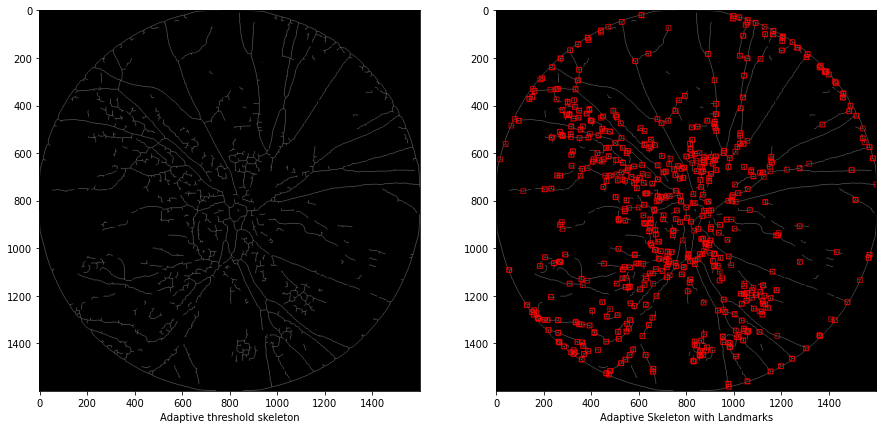

In [31]:
N,M =adaptive_skeleton.shape
temp = np.zeros((N,M,3)).astype(np.uint8)
temp[:,:,0] = adaptive_skeleton.astype(np.uint8)
temp[:,:,1] = adaptive_skeleton.astype(np.uint8)
temp[:,:,2] = adaptive_skeleton.astype(np.uint8)
temp[temp == 1] = 255
for (y, x) in land:
    cv2.rectangle(temp, (x-10,y-10), (x+10, y+10), (255,0,0), 2)
    
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(adaptive_skeleton, cmap='gray')
plt.xlabel('Adaptive threshold skeleton')
plt.subplot(122)
plt.imshow(temp, cmap="gray")
plt.xlabel('Adaptive Skeleton with Landmarks')

### Cálculo de larguras
Mudei pra média

In [49]:
def calculate_widths(img, landmarks):
    widths = []
    for x,y in landmarks:
        #down        
        i = x
        j = y
        vert_dist = 0
        while(j<1600 and img[i,j]!=0):
            vert_dist+=1
            j+=1
        
        #up
        i=x
        j=y
        while(j>=0 and img[i,j]!=0 ):
            vert_dist+=1
            j-=1
        
        #right
        horiz_dist = 0
        i = x
        j = y
        while(i<1600 and img[i,j]!=0):
            horiz_dist+=1
            i+=1

        #left
        i=x
        j=y
        while(i>=0 and img[i,j]!=0):
            horiz_dist+=1
            i-=1
        
        #down right
        i=x
        j=y
        s_diag_dist=0
        while(i<1600 and j<1600 and img[i,j]!=0):
            i+=1
            j+=1
            s_diag_dist+=1
        
        #up left
        i=x
        j=y
        while(i>=0 and j>=0 and img[i,j]!=0):
            i-=1
            j-=1
            s_diag_dist+=1

        #down left
        i=x
        j=y
        p_diag_dist=0
        while(i>=0 and j<1600 and img[i,j]!=0):
            i-=1
            j+=1
            p_diag_dist+=1

        #up right
        i=x
        j=y
        while(i<1600 and j>=0 and img[i,j]!=0):
            i+=1
            j-=1
            p_diag_dist+=1
#         min_width = np.min([vert_dist, horiz_dist, p_diag_dist, s_diag_dist])
        mean_width = np.mean([vert_dist, horiz_dist, p_diag_dist, s_diag_dist])
        widths.append([(x,y), np.ceil(mean_width).astype(int)])
    return widths

In [50]:
widths = calculate_widths(adaptive_skeleton, land)

In [51]:
def make_circle(radius):
    d = int(2*radius+1)
    rx, ry = d/2, d/2
    x,y = np.indices((d,d))
    return ((np.abs(np.hypot(rx-x, ry-y)-radius)) < 0.5).astype(np.uint8)

In [52]:
def mark_intersections_and_intersections(widths, skeleton_img):
    bifurcations = []
    intersections = []
    for (x,y), width in widths:
        diam = 12*width
        radius = diam//2
        if(x-radius < 0 or y-radius < 0 or x+radius+1>skeleton_img.shape[0] or y+radius+1 > skeleton_img.shape[1]):
          continue
        circle = make_circle(radius)
        sub_img = skeleton_img[x-radius:x+radius+1, y-radius:y+radius+1].astype(bool)
        
        circle_sum = np.sum(np.bitwise_and(sub_img, circle))
        if(circle_sum == 3):
            bifurcations.append((x,y))
        elif(circle_sum == 4):
            intersections.append((x,y))
    return bifurcations, intersections

In [53]:
bifurcations, intersections = mark_intersections_and_intersections(widths, adaptive_skeleton)
print(len(bifurcations), len(intersections))

325 222


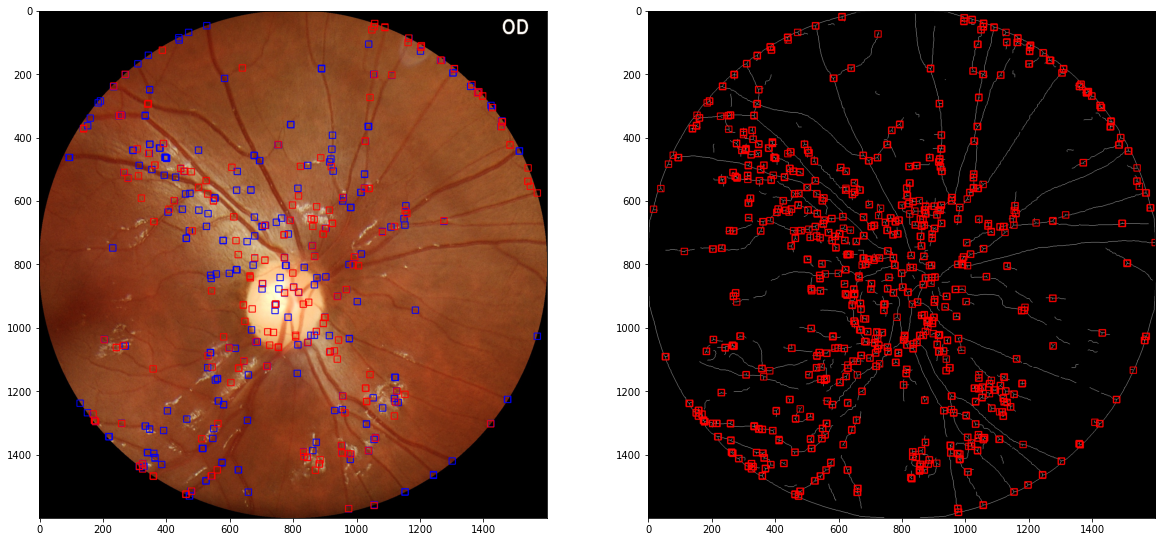

In [54]:
final = img

for (y,x) in bifurcations:
    cv2.rectangle(final, (x-10,y-10), (x+10, y+10), (0,0,255), 2)
for (y,x) in intersections:
    cv2.rectangle(final, (x-10,y-10), (x+10, y+10), (255,0,0), 2)


plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(final)
plt.subplot(122)
plt.imshow(temp)